<a href="https://colab.research.google.com/github/vishalgimhan/MachineLearning-Learn/blob/main/Feature_Engineering_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Feature Engineering

The goal of feature engineering is simply to make your data better suited to the problem at hand.



*   improve a model's predictive performance
*   reduce computational or data needs
*   improve interpretability of the results



Example - Concrete Formulations

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv('/content/drive/MyDrive/Datasets/concrete.csv')
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


We'll first establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful.

In [8]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score: .4}")

MAE Baseline Score:  8.232


Three new ratio features to the dataset.

In [9]:
# Create synthetic features
X['FCRatio'] = X['FineAggregate']/X['CoarseAggregate']
X['AggCmtRatio'] = (X['CoarseAggregate']+X['FineAggregate'])/X['Cement']
X['WtrCmtRatio'] = X['Water']/X['Cement']

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion='absolute_error', random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring='neg_mean_absolute_error'
)
score = -1 * score.mean()

print(f"MAE features with Ratio Features: {score:.4}")

MAE features with Ratio Features: 7.948


And sure enough, performance improved! This is evidence that these new ratio features exposed important information to the model that it wasn't detecting before.

#1. Mutual Information

A great first step is to construct a ranking with a feature utility metric, a function measuring associations between a feature and the target.


The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.

Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

Example - 1985 Automobiles

goal for this dataset is to predict a car's price (the target) from 23 of the car's features, such as make, body_style, and horsepower

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")

df = pd.read_csv("/content/drive/MyDrive/Datasets/autos.csv")
df.head()

<ipython-input-10-f3260edb82f6>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features.
As a rule of thumb, anything that must have a float dtype is not discrete. Categoricals (object or
categorial dtype) can be treated as discrete by giving them a label encoding.

In [11]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
  X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = (X.dtypes == int)
discrete_features.head()

symboling       True
make            True
fuel_type       True
aspiration      True
num_of_doors    True
dtype: bool

In [12]:
X.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
1,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
2,1,0,0,0,2,1,0,0,94.5,171.2,...,6,152,0,2.68,3.47,9,154,5000,19,26
3,2,1,0,0,4,2,1,0,99.8,176.6,...,4,109,0,3.19,3.40,10,102,5500,24,30
4,2,1,0,0,4,2,2,0,99.4,176.6,...,5,136,0,3.19,3.40,8,115,5500,18,22


Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif). Our target, price, is real-valued.

In [13]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
  mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
  mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
  mi_scores = mi_scores.sort_values(ascending=False)
  return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  #show a few features with their MI scores

curb_weight          1.491174
highway_mpg          0.960302
length               0.606673
bore                 0.485994
stroke               0.383612
num_of_cylinders     0.331445
compression_ratio    0.133235
fuel_type            0.048120
Name: MI Scores, dtype: float64

a bar plot to make comparisions easier:

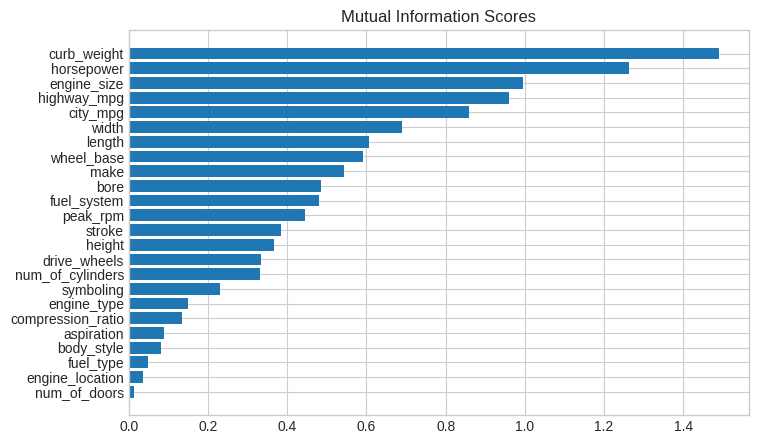

In [14]:
def plot_mi_scores(scores):
  scores = scores.sort_values(ascending=True)
  width = np.arange(len(scores))
  ticks = list(scores.index)
  plt.barh(width, scores)
  plt.yticks(width, ticks)
  plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores)

the high-scoring curb_weight feature exhibits a strong relationship with price, the target.

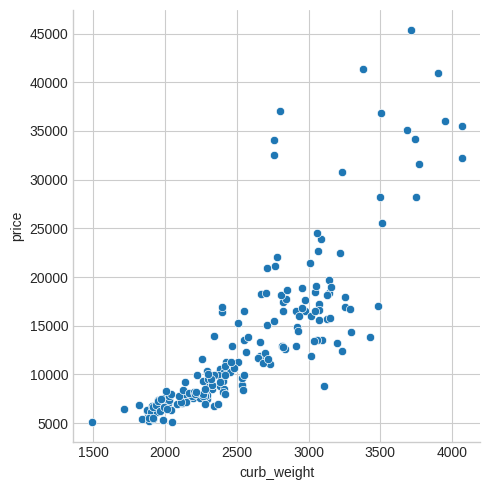

In [15]:
sns.relplot(x="curb_weight", y="price", data=df)

The fuel_type feature has a fairly low MI score, but as we can see from the figure, it clearly separates
two price populations with different trends within the horsepower feature.

This indicates that fuel_type contributes an interaction effect and might not be unimportant after all.
Before deciding a feature is unimportant from its MI score, it's good to investigate any possible
interaction effects -- domain knowledge can offer a lot of guidance here.

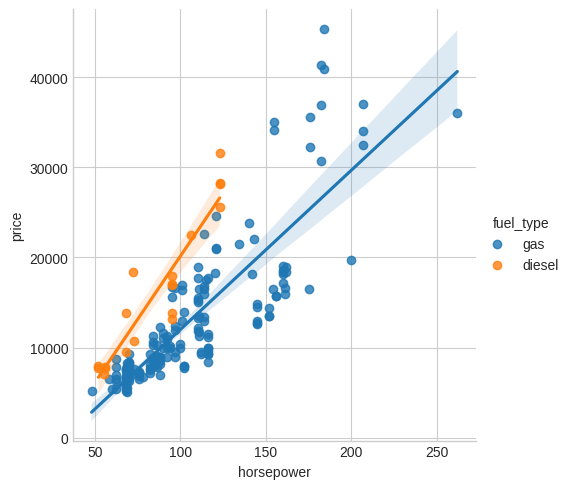

In [16]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=df)

#Exercise

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# Set Matplotlib defaults
#plt.style.use("seaborn-whitegrid")
sns.set(style="whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [18]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/Datasets/ames.csv")


# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [19]:
for colname in df.columns:
  print(colname)

MSSubClass
MSZoning
LotFrontage
LotArea
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
YearBuilt
YearRemodAdd
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Heating
HeatingQC
CentralAir
Electrical
FirstFlrSF
SecondFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
TotRmsAbvGrd
Functional
Fireplaces
FireplaceQu
GarageType
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
Threeseasonporch
ScreenPorch
PoolArea
PoolQC
Fence
MiscFeature
MiscVal
MoSold
YearSold
SaleType
SaleCondition
SalePrice


let's review the meaning of mutual information by looking at a few features

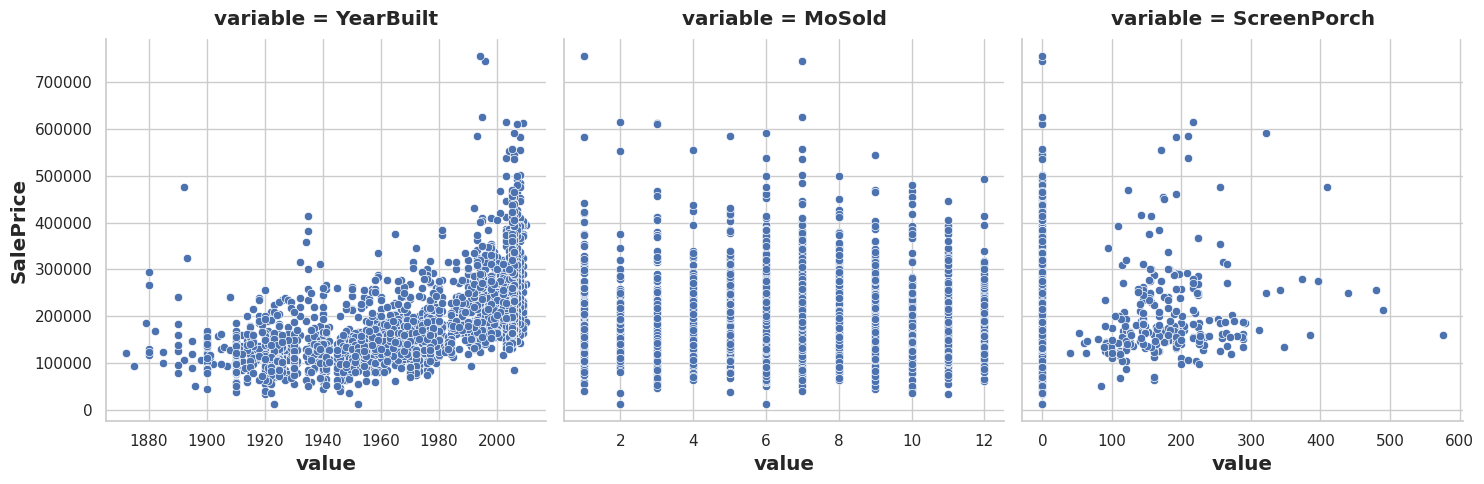

In [20]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

1) Understand Mutual Information

Based on the plots, YearBuilt should have the highest MI score since knowing the year tends to constrain
SalePrice to a smaller range of possible values. This is generally not the case for MoSold, however.

Finally, since ScreenPorch is usually just one value, 0, on average it won't tell you much about SalePrice
(though more than MoSold) .

In [21]:
#Use the make_mi_scores function to compute mutual information scores

X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64
ExterCond           0.020934
KitchenAbvGr        0.017677
BsmtHalfBath        0.013719
LotConfig           0.013637
ScreenPorch         0.012981
PoolArea            0.012831
MiscVal             0.010997
LowQualFinSF        0.009328
Heating             0.007622
Functional          0.006380
MiscFeature         0.004322
Street              0.003381
Condition2          0.003176
RoofMatl            0.002620
PoolQC              0.001370
Utilities           0.000291
Thre

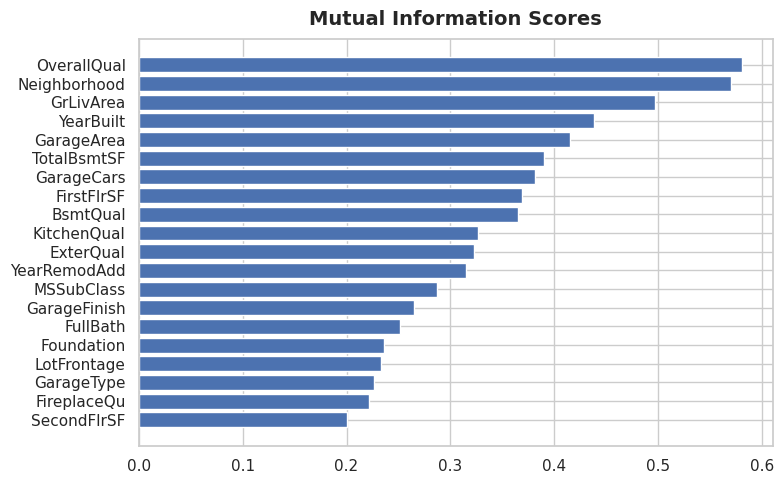

In [22]:
#Now examine the scores using the functions in this cell. Look especially at top and bottom ranks.

print(mi_scores.head(20))
print(mi_scores.tail(20))

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

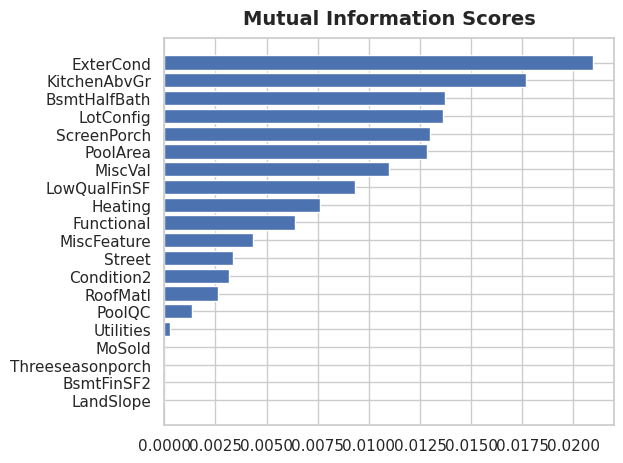

In [23]:
plot_mi_scores(mi_scores.tail(20))

2) Examine MI Scores

Do the scores seem reasonable? Do the high scoring features represent things you'd think most people would value in a home? Do you notice any themes in what they describe?

Some common themes among most of these features are:

*  Location: Neighborhood
*  Size: all of the Area and SF features, and counts like FullBath and GarageCars
*  Quality: all of the Qual features
*  Year: YearBuilt and YearRemodAdd
*  Types: descriptions of features and styles like Foundation and GarageType

These are all the kinds of features you'll commonly see in real-estate listings (like on Zillow),
It's good then that our mutual information metric scored them highly. On the other hand, the lowest
ranked features seem to mostly represent things that are rare or exceptional in some way, and so wouldn't
be relevant to the average home buyer.

investigate possible interaction effects for the BldgType feature. This feature describes the broad structure of the dwelling in five categories:

Bldg Type (Nominal): Type of dwelling

  * 1Fam    Single-family Detached
  * 2FmCon    Two-family Conversion; originally built as one-family dwelling
  * Duplx    Duplex
  * TwnhsE    Townhouse End Unit
  * TwnhsI    Townhouse Inside Unit

The BldgType feature didn't get a very high MI score. A plot confirms that the categories in BldgType
don't do a good job of distinguishing values in SalePrice (the distributions look fairly similar,
in other words):

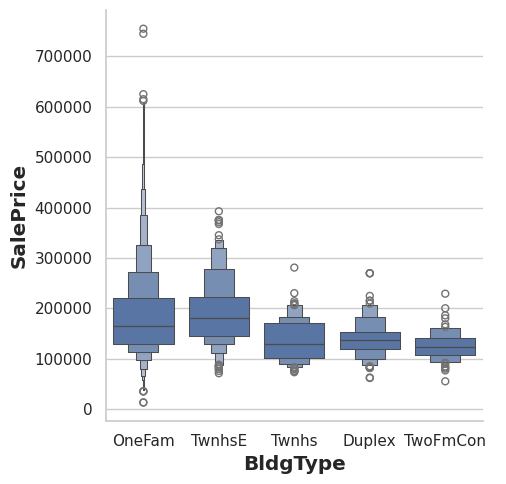

In [24]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

Still, the type of a dwelling seems like it should be important information.
Investigate whether BldgType produces a significant interaction with either of the following:

* GrLivArea  # Above ground living area
* MoSold     # Month sold

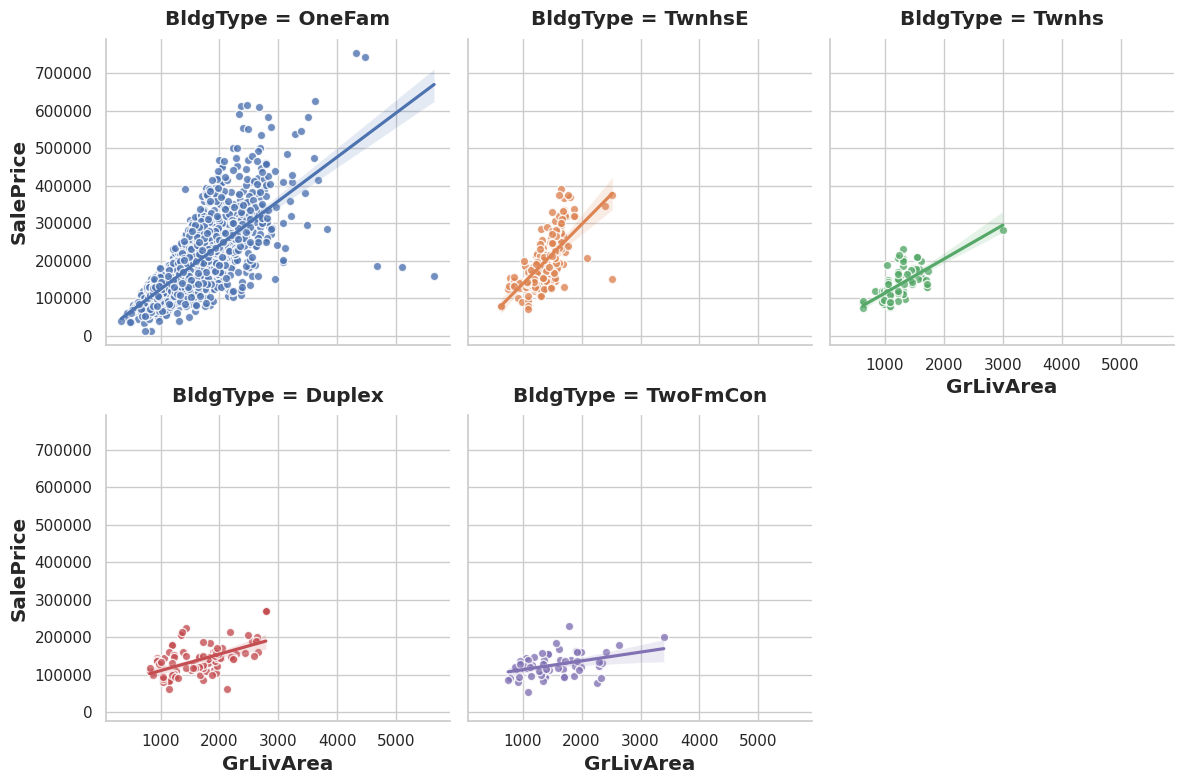

In [25]:
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

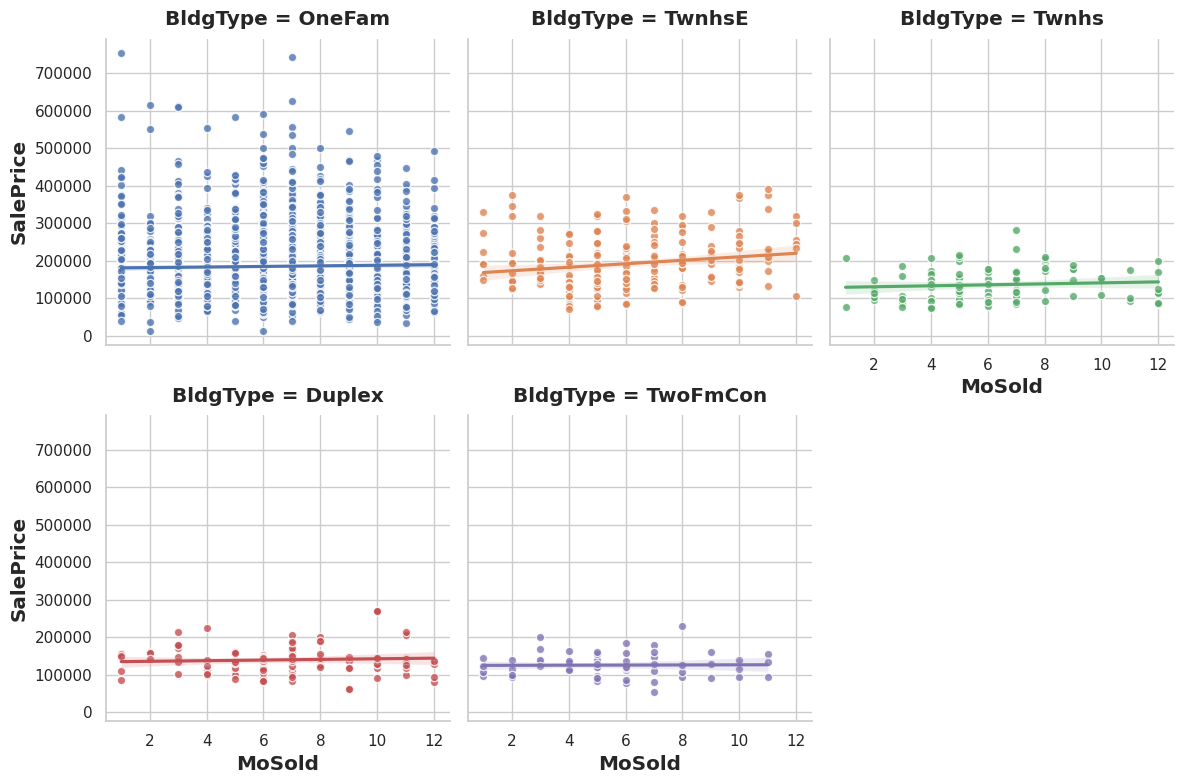

In [26]:
feature = "MoSold"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The trend lines being significantly different from one category to the next indicates an interaction effect.

3) Discover Interactions

The trends lines within each category of BldgType are clearly very different, indicating an interaction between these features. Since knowing BldgType tells us more about how GrLivArea relates to SalePrice, we should consider including BldgType in our feature set.

The trend lines for MoSold, however, are almost all the same. This feature hasn't become more informative for knowing BldgType.

A First Set of Development Features

start to build up a more informative feature set through combinations of the original features you
identified as having high potential.

In [27]:
mi_scores.head(10)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
Name: MI Scores, dtype: float64

Do you recognize the themes here? Location, size, and quality. You needn't restrict development to only these top features, but you do now have a good place to start.

Combining these top features with other related features, especially those you've identified as creating
interactions, is a good strategy for coming up with a highly informative set of features to train your
model on.

#Creating Features

In [28]:
#Once you've identified a set of features with some potential, it's time to start developing them.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize= 14,
    titlepad = 10,
)

accidents = pd.read_csv('/content/drive/MyDrive/Datasets/accidents.csv')
autos = pd.read_csv('/content/drive/MyDrive/Datasets/autos.csv')
concrete = pd.read_csv('/content/drive/MyDrive/Datasets/concrete.csv')
customer = pd.read_csv('/content/drive/MyDrive/Datasets/customer.csv')

<ipython-input-29-e91fd4708baf>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Tips on Discovering New Features

* dataset's data documentation
* acquire domain knowledge
* Study previous work.
* Use data visualization

Mathematical Transforms

Automobile Dataset

The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:

In [30]:
autos['stroke_ratio'] = autos.stroke / autos.bore

autos[['stroke','bore','stroke_ratio']].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


The more complicated a combination is, the more difficult it will be for a model to learn, like this formula for an engine's "displacement", a measure of its power:


In [31]:
autos["displacement"] = ((np.pi*(0.5*autos.bore)**2)*autos.stroke*autos.num_of_cylinders)

autos[['stroke','bore','num_of_cylinders','displacement']].head()

,stroke,bore,num_of_cylinders,displacement
0,2.68,3.47,4,101.377976
1,2.68,3.47,4,101.377976
2,3.47,2.68,6,117.446531
3,3.40,3.19,4,108.695147
4,3.40,3.19,5,135.868934


Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms.

The distribution of WindSpeed in US Accidents is highly skewed, for instance. In this case the
logarithm is effective at normalizing it:

In [32]:
accidents["WindSpeed"]

0        16.0
1         9.2
2         8.1
3         5.8
4         7.0
         ... 
99995     8.0
99996    11.5
99997     8.1
99998    13.0
99999     3.0
Name: WindSpeed, Length: 100000, dtype: float64

In [33]:
## If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)
accidents["LogWindSpeed"]

0        2.833213
1        2.322388
2        2.208274
3        1.916923
4        2.079442
           ...   
99995    2.197225
99996    2.525729
99997    2.208274
99998    2.639057
99999    1.386294
Name: LogWindSpeed, Length: 100000, dtype: float64

<ipython-input-34-e23849fa5f3e>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
<ipython-input-34-e23849fa5f3e>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1])


<Axes: xlabel='LogWindSpeed', ylabel='Density'>

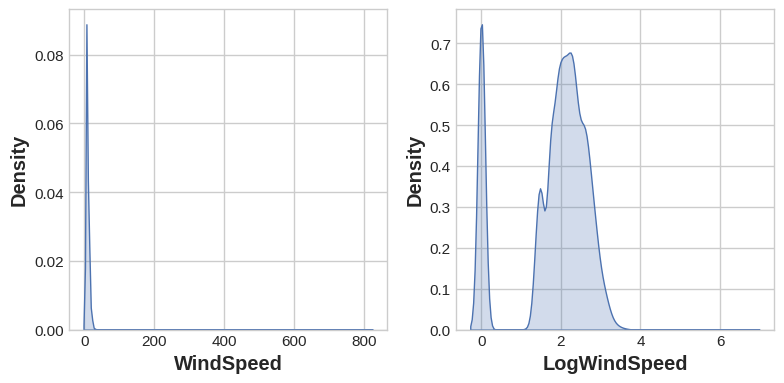

In [34]:
# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1])

#Counts

Features describing the presence or absence of something often come in sets, the set of risk factors
for a disease, say. You can aggregate such features by creating a count.

In [35]:
#In Traffic Accidents are several features indicating whether some roadway object was near the accident.

roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)
#accidents["RoadwayFeatures"]

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


In [36]:
#You could also use a dataframe's built-in methods to create boolean values.

#In the Concrete dataset are the amounts of components in a concrete formulation. Many formulations lack
#one or more components (that is, the component has a value of 0).

components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


#Building-Up and Breaking-Down Features

Often you'll have complex strings that can usefully be broken into simpler pieces.

* ID numbers: '123-45-6789'
* Phone numbers: '(999) 555-0123'
* Street addresses: '8241 Kaggle Ln., Goose City, NV'
* Internet addresses: 'http://www.kaggle.com
* Product codes: '0 36000 29145 2'
* Dates and times: 'Mon Sep 30 07:06:05 2013'

Features like these will often have some kind of structure that you can make use of. US phone numbers,
for instance, have an area code

In [37]:
#The Customer Lifetime Value dataset contains features describing customers of an insurance company.
#From the Policy feature, we could separate the Type from the Level of coverage:

customer[["Type", "Level"]] = (  # Create two new features
    customer["Policy"]           # from the Policy feature
    .str                         # through the string accessor
    .split(" ", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)
customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


In [38]:
#You could also join simple features into a composed feature if you had reason to believe there was
#some interaction in the combination:

autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style","make_and_style"]].head(10)

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan
5,audi,sedan,audi_sedan
6,audi,sedan,audi_sedan
7,audi,wagon,audi_wagon
8,audi,sedan,audi_sedan
9,bmw,sedan,bmw_sedan


#Group Transforms

aggregate information across multiple rows grouped by some category.

Using an aggregation function, a group transform combines two features: a categorical feature that
provides the grouping and another feature whose values you wish to aggregate.

In [39]:
#For an "average income by state", you would choose State for the grouping feature, mean for the
#aggregation function, and Income for the aggregated feature.

customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)
customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


In [40]:
#Other handy methods include max, min, median, var, std, and count.

#Here's how you could calculate the frequency with which each state occurs in the dataset:

customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")/customer.State.count()
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


In [41]:
#You could use a transform like this to create a "frequency encoding" for a categorical feature.

In [42]:
#If you're using training and validation splits, to preserve their independence, it's best to create a
#grouped feature using only the training set and then join it to the validation set. We can use the
#validation set's merge method after creating a unique set of values with drop_duplicates on the training set:

#Create Splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Basic,370.308485
1,Basic,370.308485
2,Basic,370.308485
3,Extended,483.733182
4,Basic,370.308485
5,Basic,370.308485
6,Basic,370.308485
7,Premium,655.758688
8,Basic,370.308485
9,Basic,370.308485


#Tips on Creating Features
It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:

* Linear models learn sums and differences naturally, but can't learn anything more complex.
* Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
* Linear models and neural nets generally do better with normalized features.
Neural nets especially need features scaled to values not too far from 0.
Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
* Tree models can learn to approximate almost any combination of features, but when a combination is especially important
they can still benefit from having it explicitly created, especially when data is limited.
* Counts are especially helpful for tree models, since these models don't have a natural way of aggregating
information across many features at once.

#Exercise

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


# Prepare data
df = pd.read_csv("/content/drive/MyDrive/Datasets/ames.csv")
X = df.copy()
y = X.pop("SalePrice")

In [45]:
#Since we're using XGBoost (a tree-based model), we'll focus on ratios and sums.

1) Create Mathematical Transforms

In [46]:
#Create the following features:

#LivLotRatio: the ratio of GrLivArea to LotArea
#Spaciousness: the sum of FirstFlrSF and SecondFlrSF divided by TotRmsAbvGrd
#TotalOutsideSF: the sum of WoodDeckSF, OpenPorchSF, EnclosedPorch, Threeseasonporch, and ScreenPorch

X_1 = pd.DataFrame()  # dataframe to hold new features

X_1["LivLotRatio"] = df.GrLivArea / df.LotArea
X_1["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF)/df.TotRmsAbvGrd
X_1["TotalOutsideSF"] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df.Threeseasonporch +df.ScreenPorch


In [47]:
#If you've discovered an interaction effect between a numeric feature and a categorical feature, you might want to model it explicitly using a one-hot encoding, like so:

# One-hot encode Categorical feature, adding a column prefix "Cat"
#X_new = pd.get_dummies(df.Categorical, prefix="Cat")

# Multiply row-by-row
#X_new = X_new.mul(df.Continuous, axis=0)

# Join the new features to the feature set
#X = X.join(X_new)

2) Interaction with a Categorical

In [48]:
#We discovered an interaction between BldgType and GrLivArea in Exercise 2.

# One-hot encode BldgType. Use `prefix="Bldg"` in `get_dummies`
X_2 = pd.get_dummies(df.BldgType, prefix="Bldg")
# Multiply
X_2 = X_2.mul(df.GrLivArea, axis = 0)

X_2.head()

,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon
0,0.0,1656.0,0.0,0.0,0.0
1,0.0,896.0,0.0,0.0,0.0
2,0.0,1329.0,0.0,0.0,0.0
3,0.0,2110.0,0.0,0.0,0.0
4,0.0,1629.0,0.0,0.0,0.0


3) Count Feature

In [49]:
#Let's try creating a feature that describes how many kinds of outdoor areas a dwelling has. Create a feature PorchTypes that counts how many of the following are greater than 0.0:
#WoodDeckSF,OpenPorchSF,EnclosedPorchThreeseasonporch,ScreenPorch

X_3 = pd.DataFrame()
#components = ["WoodDeckSF","OpenPorchSF","EnclosedPorch","Threeseasonporch","ScreenPorch"]
X_3["PorchTypes"] = df[["WoodDeckSF",
                      "OpenPorchSF",
                      "EnclosedPorch",
                      "Threeseasonporch",
                      "ScreenPorch",
                      ]].gt(0.0).sum(axis=1)

X_3.head()


,PorchTypes
0,2
1,2
2,2
3,0
4,2


4) Break Down a Categorical Feature

In [50]:
#MSSubClass describes the type of a dwelling:
df.MSSubClass.unique()

array(['One_Story_1946_and_Newer_All_Styles', 'Two_Story_1946_and_Newer',
       'One_Story_PUD_1946_and_Newer',
       'One_and_Half_Story_Finished_All_Ages', 'Split_Foyer',
       'Two_Story_PUD_1946_and_Newer', 'Split_or_Multilevel',
       'One_Story_1945_and_Older', 'Duplex_All_Styles_and_Ages',
       'Two_Family_conversion_All_Styles_and_Ages',
       'One_and_Half_Story_Unfinished_All_Ages',
       'Two_Story_1945_and_Older', 'Two_and_Half_Story_All_Ages',
       'One_Story_with_Finished_Attic_All_Ages',
       'PUD_Multilevel_Split_Level_Foyer',
       'One_and_Half_Story_PUD_All_Ages'], dtype=object)

In [51]:
#You can see that there is a more general categorization described (roughly) by the first word of each category.
#Create a feature containing only these first words by splitting MSSubClass at the first underscore _.

X_4 = pd.DataFrame()

X_4["MSClass"] = df.MSSubClass.str.split("_",n=1,expand=True)[0]

X_4.head()

,MSClass
0,One
1,One
2,One
3,One
4,Two


5) Use a Grouped Transform

In [52]:
#The value of a home often depends on how it compares to typical homes in its neighborhood.
#Create a feature MedNhbdArea that describes the median of GrLivArea grouped on Neighborhood.

X_5 = pd.DataFrame()

X_5["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")

X_5.head()


,MedNhbdArea
0,1200.0
1,1200.0
2,1200.0
3,1200.0
4,1560.0


In [53]:
#Now you've made your first new feature set! If you like, you can run the cell below to score the model
#with all of your new features added:

X_new = X.join([X_1, X_2, X_3, X_4, X_5])
score_dataset(X_new, y)

0.13954039591355258

#4. Clustering With K-Means

In [ ]:
#Untangle complex spatial relationships with cluster labels.

#Clustering simply means the assigning of data points to groups based upon how similar the points are to
#each other. A clustering algorithm makes "birds of a feather flock together," so to speak.

#Adding a feature of cluster labels can help machine learning models untangle complicated relationships of
#space or proximity.

In [ ]:
#Cluster Labels as a Feature

#Applied to a single real-valued feature, clustering acts like a traditional "binning" or "discretization"
#transform. On multiple features, it's like "multi-dimensional binning" (sometimes called vector quantization).

In [ ]:
#K-Means Clustering

#K-means clustering measures similarity using ordinary straight-line distance (Euclidean distance, in other
#words). It creates clusters by placing a number of points, called centroids, inside the feature-space.
#Each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in
#"k-means" is how many centroids (that is, clusters) it creates. You define the k yourself.

#You could imagine each centroid capturing points through a sequence of radiating circles. When sets of
#circles from competing centroids overlap they form a line. The result is what's called a Voronoi tessallation.
#The tessallation shows you to what clusters future data will be assigned; the tessallation is essentially
#what k-means learns from its training data.

In [ ]:
#It's a simple two-step process. The algorithm starts by randomly initializing some predefined number
#(n_clusters) of centroids. It then iterates over these two operations:

#assign points to the nearest cluster centroid
#move each centroid to minimize the distance to its points

#It iterates over these two steps until the centroids aren't moving anymore, or until some maximum number
#of iterations has passed (max_iter).

#It often happens that the initial random position of the centroids ends in a poor clustering. For this
#reason the algorithm repeats a number of times (n_init) and returns the clustering that has the least
#total distance between each point and its centroid, the optimal clustering.

In [ ]:
#You may need to increase the max_iter for a large number of clusters or n_init for a complex dataset.
#Ordinarily though the only parameter you'll need to choose yourself is n_clusters (k, that is).

In [54]:
#Example - California Housing

#As spatial features, California Housing's 'Latitude' and 'Longitude' make natural candidates for k-means
#clustering. In this example we'll cluster these with 'MedInc' (median income) to create economic segments
#in different regions of California.

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight = "bold",
    labelsize = "large",
    titleweight = "bold",
    titlesize = 14,
    titlepad = 10,
)

df = pd.read_csv("/content/drive/MyDrive/Datasets/housing.csv")
X = df.loc[: , ["MedInc","Latitude","Longitude"]]
X.head()

<ipython-input-54-ecf96a8ce50a>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [63]:
#Since k-means clustering is sensitive to scale, it can be a good idea rescale or normalize data with
#extreme values. Our features are already roughly on the same scale, so we'll leave them as-is.

# Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,MedInc,Latitude,Longitude,Cluster,MedHouseVal
0,8.3252,37.88,-122.23,5,4.526
1,8.3014,37.86,-122.22,5,3.585
2,7.2574,37.85,-122.24,5,3.521
3,5.6431,37.85,-122.25,5,3.413
4,3.8462,37.85,-122.25,5,3.422


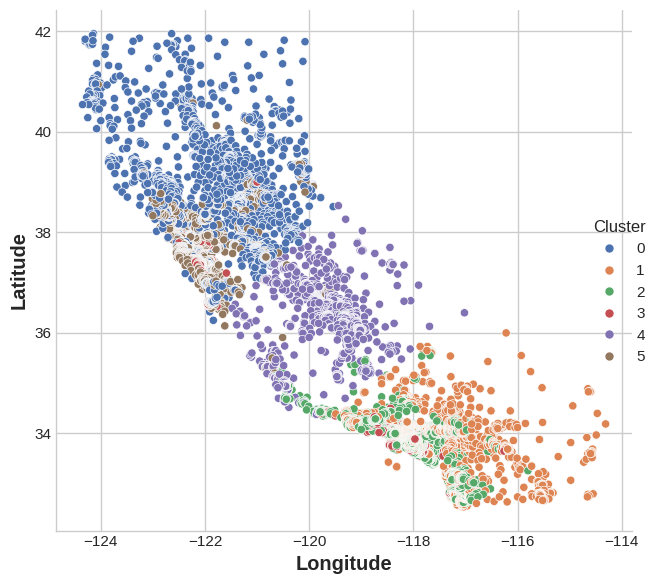

In [64]:
#a scatter plot that shows the geographic distribution of the clusters.
#It seems like the algorithm has created separate segments for higher-income areas on the coasts.

sns.relplot(
    x="Longitude", y="Latitude", hue="Cluster", data=X, height=6,
);

In [ ]:
#The target in this dataset is MedHouseVal
#These box-plots show the distribution of the target within each cluster.
#If the clustering is informative, these distributions should, for the most part, separate across MedHouseVal, which is indeed what we see.

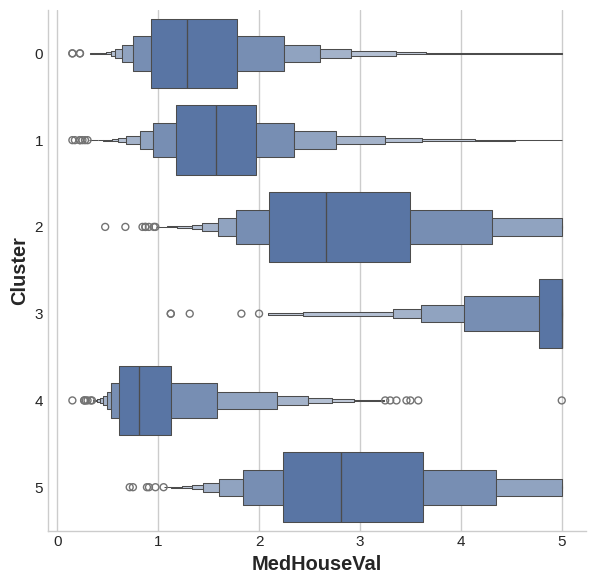

In [65]:
X["MedHouseVal"] = df["MedHouseVal"]

sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6);

#Exercise

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


# Prepare data
df = pd.read_csv("/content/drive/MyDrive/Datasets/ames.csv")

<ipython-input-66-aa8337a9592c>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [ ]:
#The k-means algorithm is sensitive to scale.
#As a rule of thumb, if the features are already directly comparable (like a test result at different times), then you would not want to rescale. On the other hand, features that aren't on comparable scales (like height and weight) will usually benefit from rescaling.
#you should try to use common sense, remembering that features with larger values will be weighted more heavily.

1) Scaling Features

In [ ]:
#Features:

#1.Latitude and Longitude of cities in California
#2.Lot Area and Living Area of houses in Ames, Iowa
#3.Number of Doors and Horsepower of a 1989 model car

#1.No, since rescaling would distort the natural distances
#2.Either choice could be reasonable, but because the living area of a home tends to be more valuable per square foot, it would make sense to rescale these features so that lot area isn't weighted in the clustering out of proportion to its effect on SalePrice, if that is what you were trying to predict.
#3.Yes, since these don't have comparable units. Without rescaling, the number of doors in a car (usually 2 or 4) would have negligible weight compared to its horsepower (usually in the hundreds).

2) Create a Feature of Cluster Labels

In [67]:
#Creating a k-means clustering with the following parameters:

#features: LotArea, TotalBsmtSF, FirstFlrSF, SecondFlrSF,GrLivArea
#number of clusters: 10
#iterations: 10

X = df.copy()
y = X.pop("SalePrice")

#Define a list of the features to be used for the clustering
features = ["LotArea", "TotalBsmtSF", "FirstFlrSF", "SecondFlrSF","GrLivArea"]

#Standardize
X_scaled = X.loc[:, features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

#Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)

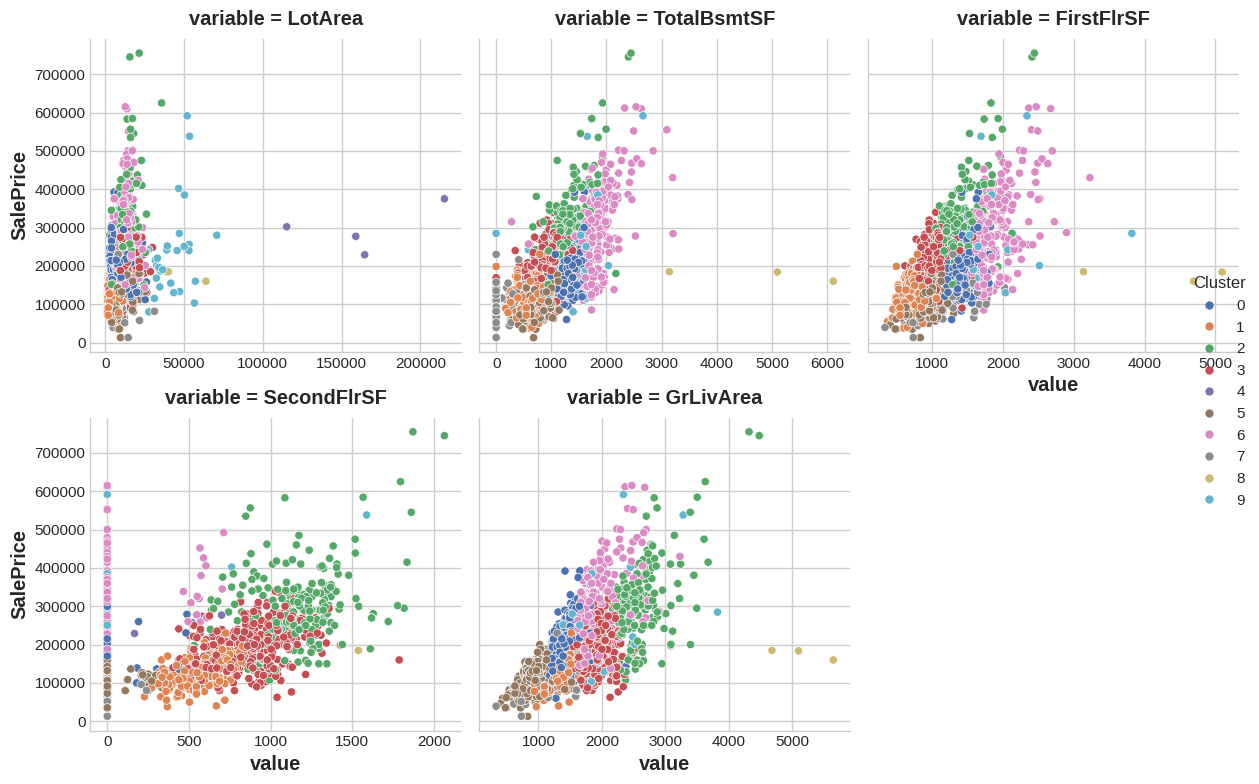

In [68]:
Xy= X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex':False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"]
    ),
);

In [69]:
#And as before, score_dataset will score your XGBoost model with this new feature added to training data.
score_dataset(X, y)


0.1424377124868132

In [ ]:
#The k-means algorithm offers an alternative way of creating features. Instead of labelling each feature with the nearest cluster centroid, it can measure the distance from a point to all the centroids and return those distances as features.

3) Cluster-Distance Features

In [70]:
#Now add the cluster-distance features to your dataset.
#You can get these distance features by using the fit_transform method of kmeans instead of fit_predict.

kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)

#Create the cluster-distance features using `fit_transform`
X_cd = kmeans.fit_transform(X_scaled)

# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

In [71]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Centroid_0,Centroid_1,Centroid_2,Centroid_3,Centroid_4,Centroid_5,Centroid_6,Centroid_7,Centroid_8,Centroid_9
0,0,0,141.0,31770.0,0,0,0,0,0,0,...,2.977514,4.324979,4.172115,3.780258,16.792665,3.696276,3.032162,3.912313,13.097627,1.677604
1,0,1,80.0,11622.0,0,0,1,0,0,1,...,1.969544,1.879362,4.654799,2.754284,19.594509,0.461371,3.852233,1.941728,15.785445,5.026636
2,0,0,81.0,14267.0,0,0,0,0,0,0,...,0.644657,2.716520,3.743687,2.616186,19.030448,1.650239,2.135609,2.888012,14.058973,3.965749
3,0,0,93.0,11160.0,0,0,1,0,0,0,...,2.868083,5.244512,3.885630,4.432911,19.392116,4.576079,0.995900,5.513141,11.373003,4.586658
4,1,0,74.0,13830.0,0,0,0,0,0,1,...,2.333623,1.313746,2.689990,0.738670,19.225117,2.175157,3.569021,2.691082,14.749591,4.469214


In [72]:
score_dataset(X, y)

0.13822238726596872

#Principal Component Analysis

In [ ]:
#Just like clustering is a partitioning of the dataset based on proximity, you could think of PCA as a partitioning of the variation in the data.
#PCA is a great tool to help you discover important relationships in the data and can also be used to create more informative features.

#PCA is typically applied to standardized data.
#With standardized data "variation" means "correlation".
#With unstandardized data "variation" means "covariance"

In [ ]:
#whole idea of PCA: instead of describing the data with the original features, we describe it with its axes of variation. The axes of variation become the new features.

#The new features PCA constructs are actually just linear combinations (weighted sums) of the original features

#These new features are called the principal components of the data. The weights themselves are called loadings. There will be as many principal components as there are features in the original dataset:

#A component's loadings tell us what variation it expresses through signs and magnitudes

#PCA also tells us the amount of variation in each component. PCA makes this precise through each component's percent of explained variance.

#however, that the amount of variance in a component doesn't necessarily correspond to how good it is as a predictor: it depends on what you're trying to predict.

PCA for Feature Engineering

In [ ]:
#There are two ways you could use PCA for feature engineering.

#as a descriptive technique - Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create
#components themselves as features - Because the components expose the variational structure of the data directly, they can often be more informative than the original features.

In [ ]:
#PCA Best Practices

#PCA only works with numeric features, like continuous quantities or counts.
#PCA is sensitive to scale. It's good practice to standardize your data before applying PCA, unless you know you have good reason not to.
#Consider removing or constraining outliers, since they can have an undue influence on the results.

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

df = pd.read_csv("/content/drive/MyDrive/Datasets/autos.csv")

<ipython-input-73-fa4a666fd1e4>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [ ]:
#We've selected four features that cover a range of properties. Each of these features also has a high MI score with the target, price.
#We'll standardize the data since these features aren't naturally on the same scale.

In [74]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop('price')
X = X.loc[:, features]

#Standardize
X_scaled = (X - X.mean(axis=0))/X.std(axis=0)

In [75]:
#fit scikit-learn's PCA estimator and create the principal components.

from sklearn.decomposition import PCA

#Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [76]:
#After fitting, the PCA instance contains the loadings in its components_ attribute.
#We're following the convention that calls the transformed columns in X_pca the components. We'll wrap the loadings up in a dataframe.

loadings = pd.DataFrame(pca.components_.T,          # transpose the matrix of loadings
                        columns = component_names,  # so the columns are the principal components
                        index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


In [ ]:
#The first component (PC1) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage. We might call this the "Luxury/Economy" axis.

#The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

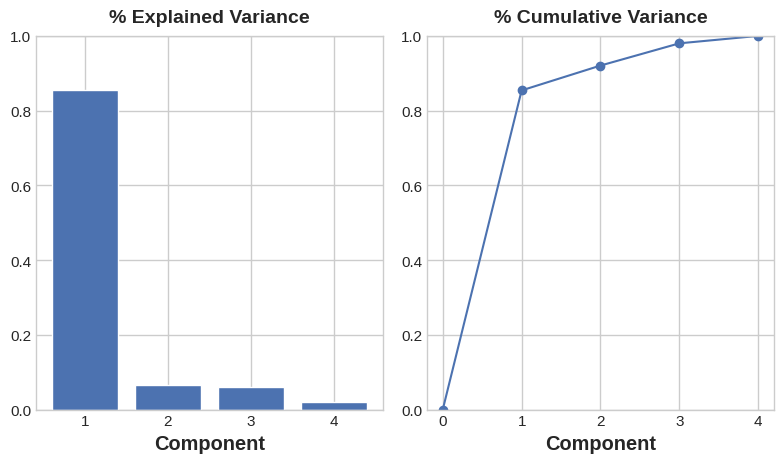

In [77]:
# Look at explained variance
plot_variance(pca);

In [78]:
#Let's also look at the MI scores of the components.
#Not surprisingly, PC1 is highly informative, though the remaining components, despite their small variance, still have a significant relationship with price.
#Examining those components could be worthwhile to find relationships not captured by the main Luxury/Economy axis.

In [79]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.014945
PC2    0.379786
PC3    0.307049
PC4    0.204539
Name: MI Scores, dtype: float64

In [80]:
#The third component shows a contrast between horsepower and curb_weight -- sports cars vs. wagons, it seems.

# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


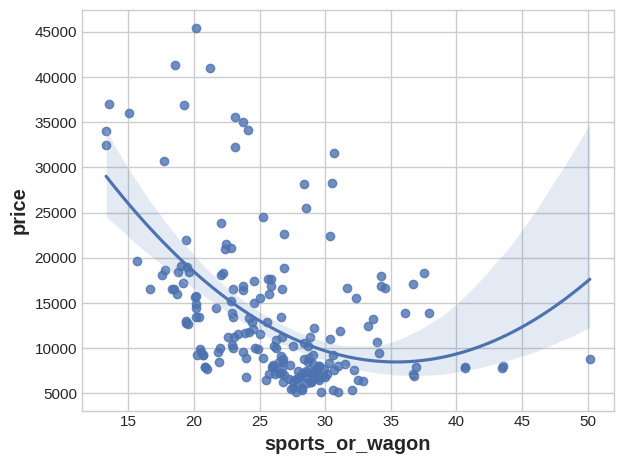

In [81]:
#To express this contrast, let's create a new ratio feature:

df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y="price", data=df, order=2);

#Exercise

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("/content/drive/MyDrive/Datasets/ames.csv")

<ipython-input-1-45b77d6ab9a9>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
#Let's choose a few features that are highly correlated with our target, SalePrice.

features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


In [ ]:
#We'll rely on PCA to untangle the correlational structure of these features and suggest relationships that might be usefully modeled with new features.

In [3]:
X = df.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                   PC1       PC2       PC3       PC4
GarageArea    0.541229  0.102375 -0.038470  0.833733
YearRemodAdd  0.427077 -0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076  0.360778 -0.666836 -0.406192
GrLivArea     0.514294  0.270700  0.742592 -0.332837


1) Interpret Component Loadings

In [ ]:
#what kind of contrast each component has captured?
#PC1 - all of the features have the same sign (positive), indicating that this component is describing a contrast between houses having large values and houses having small values for these features.
#PC3 - a little trickier. The features GarageArea and YearRemodAdd both have near-zero loadings, so let's ignore those. This component is mostly about TotalBsmtSF and GrLivArea.
#a contrast between houses with a lot of living area but small (or non-existant) basements, and the opposite: small houses with large basements.

2) Create New Features

In [4]:
# Solution 1: Inspired by loadings
X = df.copy()
y = X.pop("SalePrice")

# YOUR CODE HERE: Add new features to X.
X["living_and_basement"] = X.TotalBsmtSF+X.GrLivArea
X["garage_or_basement"] = X.GarageArea/X.GrLivArea
X["Remod_or_basement"] = X.TotalBsmtSF*X.YearRemodAdd

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.14093 RMSLE


In [5]:
# Solution 2: Uses components
X = df.copy()
y = X.pop("SalePrice")

X = X.join(X_pca)
score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.13856 RMSLE


In [ ]:
#a way you can use PCA to detect outliers in the dataset
#Outliers can have a detrimental effect on model performance, so it's good to be aware of them in case you need to take corrective action.
#PCA in particular can show you anomalous variation which might not be apparent from the original features:
#neither small houses nor houses with large basements are unusual, but it is unusual for small houses to have large basements.

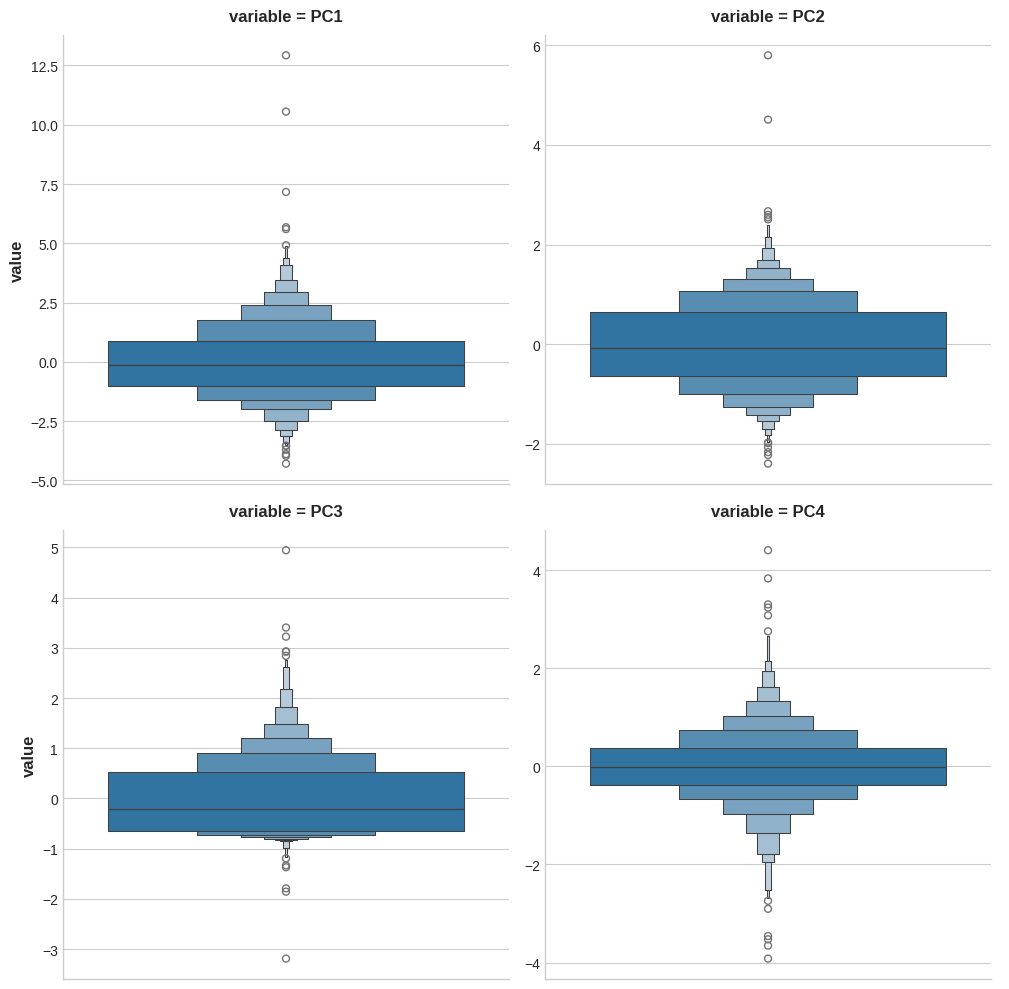

In [6]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [ ]:
#As you can see, in each of the components there are several points lying at the extreme ends of the distributions -- outliers, that is.

In [7]:
#Now run the next cell to see those houses that sit at the extremes of a component:

## You can change PC1 to PC2, PC3, or PC4
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0


3) Outlier Detection

In [ ]:
#Do you notice any patterns in the extreme values? Does it seem like the outliers are coming from some special subset of the data?

#Notice that there are several dwellings listed as Partial sales in the Edwards neighborhood that stand out.
#A partial sale is what occurs when there are multiple owners of a property and one or more of them sell their "partial" ownership of the property.

#These kinds of sales are often happen during the settlement of a family estate or the dissolution of a business and aren't advertised publicly.
#If you were trying to predict the value of a house on the open market, you would probably be justified in removing sales like these from your dataset -- they are truly outliers.

#6. Target Encoding

In [8]:
import pandas as pd

autos = pd.read_csv("/content/drive/MyDrive/Datasets/autos.csv")

In [9]:
#A target encoding is any kind of encoding that replaces a feature's categories with some number derived from the target.
#A simple and effective version is to apply a group aggregation

autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")
autos[["make", "price", "make_encoded"]]

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
...,...,...,...
188,volvo,16845,18063.181818
189,volvo,19045,18063.181818
190,volvo,21485,18063.181818
191,volvo,22470,18063.181818


In [ ]:
#This kind of target encoding is sometimes called a mean encoding.
#Applied to a binary target, it's also called bin counting.
#(Other names you might come across include: likelihood encoding, impact encoding, and leave-one-out encoding.)

Smoothing

In [ ]:
#An encoding like this presents a couple of problems, however.

#First are unknown categories. Target encodings create a special risk of overfitting, which means they need to be trained on an independent "encoding" split. When you join the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values you would have to impute somehow.
#Second are rare categories. When a category only occurs a few times in the dataset, any statistics calculated on its group are unlikely to be very accurate.

#In the Automobiles dataset, the mercurcy make only occurs once. The "mean" price we calculated is just the price of that one vehicle, which might not be very representative of any Mercuries we might see in the future. Target encoding rare categories can make overfitting more likely.

#A solution to these problems is to add smoothing. The idea is to blend the in-category average with the overall average. Rare categories get less weight on their category average, while missing categories just get the overall average.
#In pseudocode:
#encoding = weight * in_category + (1 - weight) * overall

#An easy way to determine the value for weight is to compute an m-estimate:
#weight = n / (n + m)
#where n is the total number of times that category occurs in the data. The parameter m determines the "smoothing factor".
#Larger values of m put more weight on the overall estimate.

In [ ]:
#In the Automobiles dataset there are three cars with the make chevrolet. If you chose m=2.0, then the chevrolet category would be encoded with 60% of the average Chevrolet price plus 40% of the overall average price.
#chevrolet = 0.6 * 6000.00 + 0.4 * 13285.03

#When choosing a value for m, consider how noisy you expect the categories to be.
#Does the price of a vehicle vary a great deal within each make? Would you need a lot of data to get good estimates?
#If so, it could be better to choose a larger value for m;
#if the average price for each make were relatively stable, a smaller value could be okay.

In [ ]:
#Use Cases for Target Encoding

#High-cardinality features: A feature with a large number of categories can be troublesome to encode
#Domain-motivated features: From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric.

Example

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')

df = pd.read_csv("/content/drive/MyDrive/Datasets/movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') #reduce memory footprint
#df.head()
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

<ipython-input-10-22e65afc891f>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Number of Unique Zipcodes: 3439


In [16]:
df.head()

,Movie ID,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Unknown,War,Western,(no genres listed),User ID,Age,Gender,Occupation,Zipcode,Rating
0,b'3107',1,0,0,0,0,0,0,1,0,...,0,0,0,0,b'130',35,1,18,b'50021',5
1,b'2114',0,0,0,0,0,0,0,1,0,...,0,0,0,0,b'3829',25,0,0,b'22307',4
2,b'256',0,0,0,0,1,0,0,0,0,...,0,0,0,0,b'1265',18,0,21,b'49321',1
3,b'1389',1,0,0,0,0,0,0,0,0,...,0,0,0,0,b'2896',18,1,14,b'60073',5
4,b'3635',1,0,0,0,0,0,0,0,0,...,0,0,0,0,b'5264',18,1,17,b'15217',4


In [11]:
#With over 3000 categories, the Zipcode feature makes a good candidate for target encoding, and the size of this dataset (over one-million rows) means we can spare some data to create the encoding.

#We'll start by creating a 25% split to train the target encoder.

X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]


In [14]:
#!pip install category_encoders
#The category_encoders package in scikit-learn-contrib implements an m-estimate encoder, which we'll use to encode our Zipcode feature.

from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

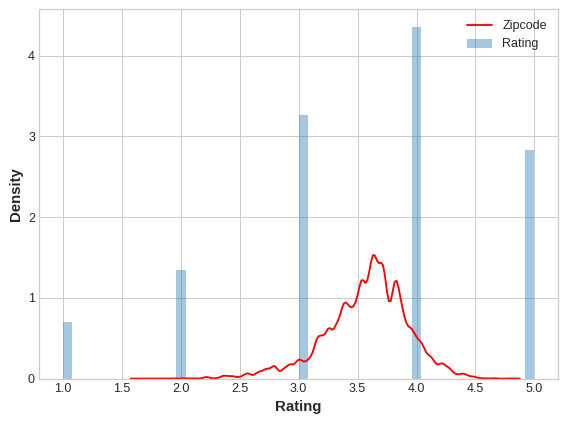

In [15]:
#Let's compare the encoded values to the target to see how informative our encoding might be.

plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

In [ ]:
#The distribution of the encoded Zipcode feature roughly follows the distribution of the actual ratings, meaning that movie-watchers differed enough in their ratings from zipcode to zipcode that our target encoding was able to capture useful information.

#Exercise

In [17]:
#!pip install category_encoders

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

df = pd.read_csv("/content/drive/MyDrive/Datasets/ames.csv")

In [18]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,3,2010,WD,Normal,189900


In [19]:
#First you'll need to choose which features you want to apply a target encoding to. Categorical features with a large number of categories are often good candidates

df.select_dtypes(["object"]).nunique()

MSSubClass       16
MSZoning          7
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     28
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          6
BsmtCond          6
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            5
Fence             5
MiscFeature       5
SaleType         10
SaleCondition     6
dtype: int64

In [20]:
#M-estimate encoding uses smoothing to improve estimates for rare categories. To see how many times a category occurs in the dataset, you can use the value_counts method.

df["SaleType"].value_counts()

SaleType
WD       2536
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: count, dtype: int64

1) Choose Features for Encoding

In [ ]:
#The Neighborhood feature looks promising. It has the most categories of any feature, and several categories are rare.
#Others that could be worth considering are SaleType, MSSubClass, Exterior1st, Exterior2nd.
#In fact, almost any of the nominal features would be worth trying because of the prevalence of rare categories.

In [22]:
#Now you'll apply a target encoding to your choice of feature.

# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

2) Apply M-Estimate Encoding

In [23]:
#Apply a target encoding to your choice of categorical features.
encoder = MEstimateEncoder(cols=["Neighborhood"], m=5.0)

# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

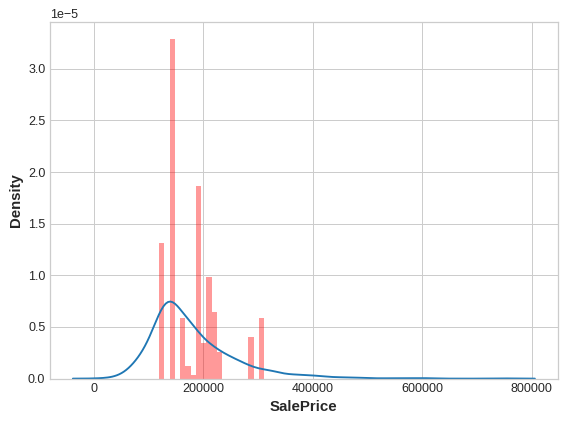

In [24]:
#see how the encoded feature compares to the target
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

In [25]:
#From the distribution plots, does it seem like the encoding is informative?

X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1434 RMSLE
Score with Encoding: 0.1398 RMSLE


In [ ]:
#Do you think that target encoding was worthwhile in this case? Depending on which feature or features you chose, you may have ended up with a score significantly worse than the baseline.
#In that case, it's likely the extra information gained by the encoding couldn't make up for the loss of data used for the encoding.

In [ ]:
#explore the problem of overfitting with target encodings. This will illustrate this importance of training fitting target encoders on data held-out from the training set.

#So let's see what happens when we fit the encoder and the model on the same dataset. To emphasize how dramatic the overfitting can be,
#we'll mean-encode a feature that should have no relationship with SalePrice, a count: 0, 1, 2, 3, 4, 5, ....

In [31]:
# Try experimenting with the smoothing parameter m
# Try 0, 1, 5, 50
m = 5

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0  # actually need one duplicate value to circumvent error-checking in MEstimateEncoder

# fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# Results
score =  score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")

Score: 0.0355 RMSLE


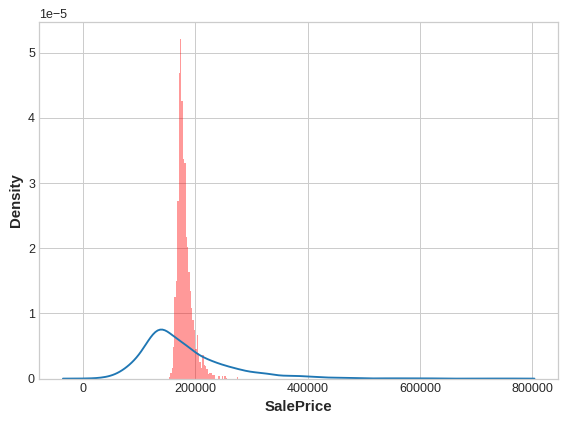

In [32]:
#Almost a perfect score!

plt.figure(dpi=90)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

In [ ]:
#And the distributions are almost exactly the same, too.

3) Overfitting with Target Encoders

In [ ]:
#how XGBoost was able to get an almost a perfect fit after mean-encoding the count feature?


In [ ]:
#Since Count never has any duplicate values, the mean-encoded Count is essentially an exact copy of the target. In other words, mean-encoding turned a completely meaningless feature into a perfect feature.

#Now, the only reason this worked is because we trained XGBoost on the same set we used to train the encoder. If we had used a hold-out set instead, none of this "fake" encoding would have transferred to the training data.

#The lesson is that when using a target encoder it's very important to use separate data sets for training the encoder and training the model. Otherwise the results can be very disappointing!